In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torchview import draw_graph
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import time
import os
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Load the cifar10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Prepare dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Define the network
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
    
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)
    
# Initialize the network
net = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4*6)
# draw the network
dd = make_dot(net(torch.randn(1, 3, 32, 32)), params=dict(net.named_parameters()))
dd.format = 'png'
dd.render('vit')
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} total trainable parameters.')
# Move everything to the GPU
net = net.to(device)
criterion = criterion.to(device)

9,523,722 total parameters.
9,523,722 total trainable parameters.


In [4]:
def train(epoch):
    pb = tqdm(total=50, unit="batch", leave=False, desc=f"Epoch {epoch} Train", position=0, file=sys.stdout)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Train with amp
        with torch.amp.autocast('cuda', enabled=use_amp):
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pb.postfix = '; Loss: %.3f | Acc: %.3f%% (%d/%d)'%(train_loss/(batch_idx+1), 100.*correct/total, correct, total)
        pb.update(1)

        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
           # % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    pb.close()
    return train_loss/(batch_idx+1), correct/total

def test(epoch):
    pb = tqdm(total=10, unit="batch", leave=False, desc=f"Epoch {epoch} Test ", position=0, file=sys.stdout)
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pb.postfix = '; Loss: %.3f | Acc: %.3f%% (%d/%d)'%(test_loss/(batch_idx+1), correct/total, correct, total)
            pb.update(1)

            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    pb.close()
    # Save checkpoint.
    
    #os.makedirs("log", exist_ok=True)
    return test_loss/(batch_idx+1), correct/total

list_train_loss = []
list_train_acc = []
list_val_loss = []
list_val_acc = []
list_lr = []

net.cuda()
use_amp = True
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 200)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

for epoch in range(0, 200):
    start = time.time()
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = test(epoch)
    
    scheduler.step() # step cosine scheduling

    list_lr.append(optimizer.param_groups[0]["lr"])
    list_train_loss.append(train_loss)
    list_train_acc.append(train_acc)
    list_val_loss.append(val_loss)
    list_val_acc.append(val_acc)
    content = f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, acc: {100*train_acc:.3f}%, val loss: {val_loss:.5f}, acc: {100*val_acc:.2f}%, time: {time.time()-start:.5f}s'
    #with open(f'log/log_ViT_patch4.txt', 'a') as appender:
    #    appender.write(content + "\n")
    print(content)

Epoch 0, lr: 0.0006000, train loss: 2.04742, acc: 25.570%, val loss: 1.75172, acc: 37.74%, time: 17.27850s   
Epoch 1, lr: 0.0005999, train loss: 1.64206, acc: 40.138%, val loss: 1.48197, acc: 47.65%, time: 16.90765s   
Epoch 2, lr: 0.0005997, train loss: 1.48273, acc: 46.220%, val loss: 1.33436, acc: 51.86%, time: 17.15901s   
Epoch 3, lr: 0.0005994, train loss: 1.37599, acc: 50.110%, val loss: 1.25130, acc: 55.05%, time: 16.69177s   
Epoch 4, lr: 0.0005991, train loss: 1.30260, acc: 53.136%, val loss: 1.20225, acc: 56.34%, time: 16.64071s   
Epoch 5, lr: 0.0005987, train loss: 1.24845, acc: 54.922%, val loss: 1.17987, acc: 58.51%, time: 17.26838s   
Epoch 6, lr: 0.0005982, train loss: 1.19166, acc: 56.746%, val loss: 1.15002, acc: 59.23%, time: 16.88461s   
Epoch 7, lr: 0.0005976, train loss: 1.16721, acc: 58.154%, val loss: 1.09667, acc: 60.27%, time: 16.91400s   
Epoch 8, lr: 0.0005970, train loss: 1.10886, acc: 60.322%, val loss: 1.06582, acc: 61.98%, time: 17.33889s   
Epoch 9, l

In [5]:
test_loss, test_acc = test(epoch)

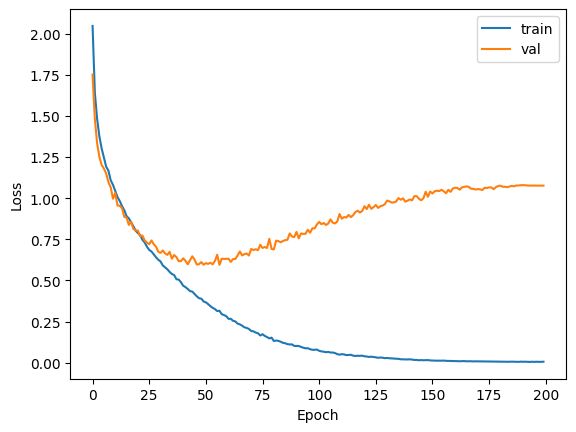

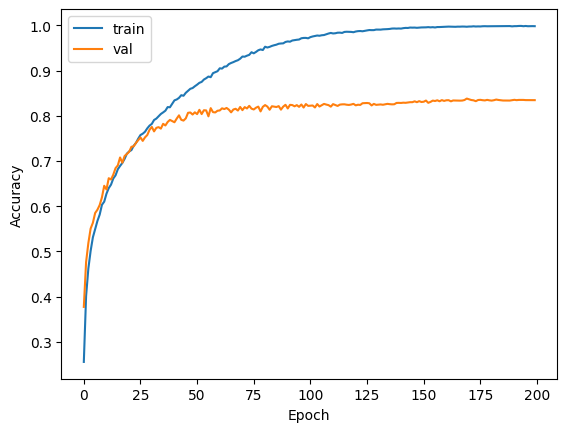

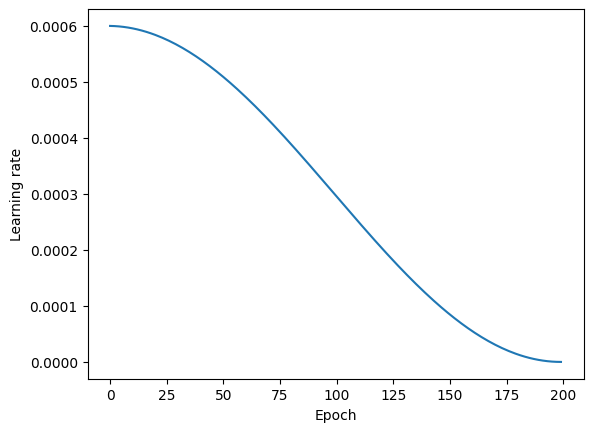

Best train loss: 0.00444, acc: 99.89%, Best val loss: 0.59438, acc: 83.82%, test loss: 1.07644, acc: 83.47%


In [6]:
best_train_acc = max(list_train_acc)
best_val_acc = max(list_val_acc)
best_train_loss = min(list_train_loss)
best_val_loss = min(list_val_loss)
plt.plot(list_train_loss)
plt.plot(list_val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()
plt.plot(list_train_acc)
plt.plot(list_val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()
plt.plot(list_lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()
print(f'Best train loss: {best_train_loss:.5f}, acc: {100*best_train_acc:.2f}%, Best val loss: {best_val_loss:.5f}, acc: {100*best_val_acc:.2f}%, test loss: {test_loss:.5f}, acc: {100*test_acc:.2f}%')